# PPG Peak Detection without Ground‑Truth Labels
**30‑s window, pseudo‑label distillation approach**

This notebook demonstrates how to build a PyTorch pipeline that loads raw PPG recordings from an HDF5 file, generates heuristic peak labels on‑the‑fly, and trains a small 1‑D U‑Net to predict a peak‑probability map.

*Assumptions*
*  HDF5 file created from the .mat dataset (one group per recording). 
*  Each group contains a `ppg` dataset (float32) and attributes `fs`, `subj_id`, `af_status`.

Created: 2025-04-18

https://iopscience.iop.org/article/10.1088/1361-6579/adb89e

In [1]:

# # If you need any extra packages:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install h5py scipy tqdm
# !pip install torchinfo

# !pip install heartpy

In [2]:
from torchinfo import summary
import h5py, math, random, os, sys, gc
import numpy as np
import scipy.signal as signal
import scipy.ndimage as ndi
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import heartpy as hp

import torch, os
from torch import nn
from torch.utils.data import Dataset, DataLoader

from unet1d import UNet1D
from PPGWindowModel import PPGWindow
from utils import *
from torch.utils.data import random_split

%matplotlib ipympl
import matplotlib.pyplot as plt 

import glob
import re
# %matplotlib
# %matplotlib notebook





In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device:', device)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"    # avoid crashes on odd ops
torch.mps.empty_cache()                            # call between val runs

Device: mps


In [4]:
# t1 = h5py.File("downloaded_files/length_full/train_ds.h5", 'r', swmr=True)
# idxs = list(t1.keys())
# t1[idxs[0]]['ppg'][:].astype('float32')
# t1[idxs[0]].attrs.get('af_status')

In [5]:
# ----------------------------- configuration -----------------------------

# H5_PATH = os.path.join('data',FOLDER_PATH,'mimic_non_af_data.h5')  # update if your file lives elsewhere
WIN_SEC = 30                      # window length in seconds
FS_ORIGINAL = 125
DEC_FACTOR = 6
FS = round(FS_ORIGINAL/DEC_FACTOR,2)                  # Hz (dataset‑wide constant)
print(FS)
WIN_LEN = int(round(WIN_SEC * FS))            # 3_750 samples
BATCH   = 32
EPOCHS  = 200                       # demo; increase to 30+ for real training

VAR_MULT=500

FOLDER_PATH = 'length_full'
DEVELOPMENT_DATA_PATH = os.path.join('data','development_dataset',FOLDER_PATH)
TRAIN_LOADER_PATH = os.path.join(DEVELOPMENT_DATA_PATH,'train_ds.pkl');
VAL_LOADER_PATH = os.path.join(DEVELOPMENT_DATA_PATH,'val_ds.pkl');
TEST_LOADER_PATH =os.path.join(DEVELOPMENT_DATA_PATH,'test_ds.pkl');

20.83


In [6]:
best_config = find_sliding_window(WIN_LEN,target_windows = 5, overlap=25)
scale_type = "norm"


if not os.path.exists(TRAIN_LOADER_PATH):
    TRAIN_PATH = f"data/{FOLDER_PATH}/train_ds.h5"
    train_ds = PPGWindow(TRAIN_PATH,best_config=best_config,scale_type=scale_type)

    if not os.path.exists(DEVELOPMENT_DATA_PATH):
        os.mkdir(DEVELOPMENT_DATA_PATH)
        
    torch.save(train_ds, TRAIN_LOADER_PATH)
else:
    train_ds = torch.load(TRAIN_LOADER_PATH, weights_only=False)

VAL_FRAC = 0.20               # 10 % of the *virtual* samples
n_total  = len(train_ds)
n_val    = int(n_total * VAL_FRAC)
n_train  = n_total - n_val

train_ds, val_ds = random_split(
    train_ds,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(42)   # reproducible
)

train_loader = DataLoader(train_ds, batch_size=BATCH,
                        shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH,
                        shuffle=True, num_workers=0, pin_memory=False)

print('Dataset ready. Example batch shapes:')
x, y,_,_= next(iter(train_loader))
print(x.shape, y.shape)   # (B, 1, 3750) (B, 3750)



Dataset ready. Example batch shapes:
torch.Size([32, 1, 625]) torch.Size([32, 625])


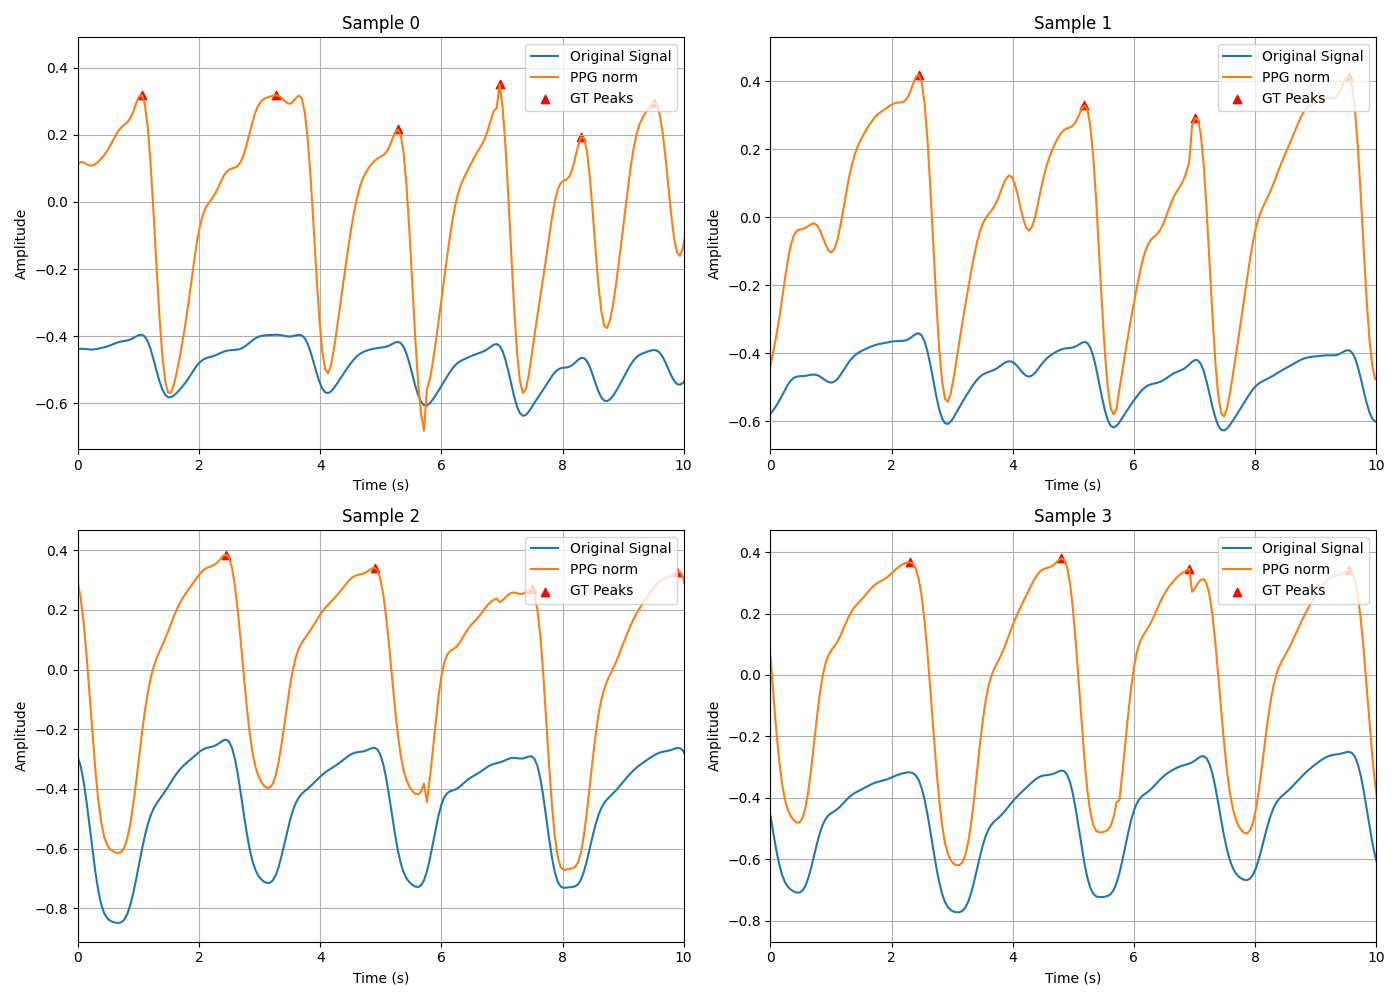

In [7]:
B, _, L = x.shape

# How many to plot
n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*5), squeeze=False)

for i in range(n_plot):
    x, y,original_signal,_ = next(iter(train_loader))
    ax = axes[i//cols][i%cols]
    seg = scale_signal(x[0,0], best_config,method = scale_type)

    # call your function instead of hp.process
    y = pseudo_peak_vector(seg, fs=FS)
    peaks = np.nonzero(y > 0)[0]
    t = np.arange(len(seg)) / FS
    input_signal = original_signal[0,0]*-1
    seg *= -1


    ax.plot(t,original_signal[0,0]*-1,label='Original Signal')
    ax.plot(t, seg, label=f'PPG {scale_type}')
    ax.scatter(t[peaks], seg[peaks], c='r', marker='^', label='GT Peaks')
    ax.set_title(f'Sample {i}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right')
    ax.grid()
    ax.set_xlim(0,10)

plt.tight_layout()
plt.show()

In [8]:
class EarlyStoppingBasic:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [9]:
# 1) Gather all labels from your training set (flattened)
counts = torch.zeros(2, dtype=torch.long)
for _, yb, _, _ in train_loader:
    flat = yb.view(-1).long()                     # ensure integer dtype
    c = torch.bincount(flat, minlength=2)         # c[0]=#zeros, c[1]=#ones
    counts += c
neg, pos = counts[0].item(), counts[1].item()
print(f"neg={neg}, pos={pos}")

# 3) Build your pos_weight from that ratio
pos_weight = torch.tensor([neg/pos], dtype=torch.float32, device=device)

# 4) Create your loss once, using that pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([ len(zeros)/len(ones) ]).to(device))

scaler = torch.amp.GradScaler(enabled=False)       # autocast handles bfloat16



neg=6488823, pos=261177


In [ ]:
model = UNet1D().to(device)
print(summary(model, input_size=(1,1, WIN_LEN)))

model = UNet1D().to(device)

LEARNING_RATE = 3e-5;
optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,'min',factor=0.1,       # drop LR to 10%
    patience=3,       # after 3 epochs of no val_loss improvement
    threshold=1e-3,   # require 0.1% improvement to count
    threshold_mode='rel',
    verbose=True      # print a message when it happens)
)
early_stopper = EarlyStoppingBasic(patience=5, min_delta=1e-3)

# Reinforcement Learning
baseline = 0.0
RL_BETA  = 0.3      # scale of the RL‐loss relative to BCE
min_rr = 0.3
max_rr = 2

WINDOW_SEC   = 30
MAX_BPM      = 240
MAX_PEAKS    = int(MAX_BPM/60 * WINDOW_SEC)   # = 120
MAX_INTERVAL = MAX_PEAKS - 1                  # = 119

def compute_reward(actions_np, fs=FS,window_sec=WINDOW_SEC,max_bpm = MAX_BPM,
                   min_rr=min_rr, max_rr=max_rr) -> float:
    idx = np.nonzero(actions_np)[0]
    if len(idx) < 2:
        raw_r = -1.0   # worst‑case penalty
    else:
        locs  = idx / fs
        diffs = np.diff(locs)
        raw_r = 0.0
        for dt in diffs:
            if   dt < min_rr: raw_r -= 1.0
            elif dt > max_rr: raw_r -= 0.1
            else:             raw_r += 1.0

    # clip to ±max_intervals
    max_intervals = int(max_bpm/60 * window_sec) - 1
    raw_r = max(min(raw_r,  max_intervals),
                -max_intervals)
    # normalize by the maximum possible “good” intervals

    return raw_r / MAX_INTERVAL

Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 625]                  --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 16, 625]              --
│    │    └─Sequential: 3-1              [1, 16, 625]              2,544
│    └─ConvBlock: 2-2                    [1, 32, 312]              --
│    │    └─Sequential: 3-2              [1, 32, 312]              14,016
│    └─ConvBlock: 2-3                    [1, 64, 156]              --
│    │    └─Sequential: 3-3              [1, 64, 156]              55,680
│    └─ConvBlock: 2-4                    [1, 128, 78]              --
│    │    └─Sequential: 3-4              [1, 128, 78]              221,952
├─ConvBlock: 1-2                         [1, 128, 39]              --
│    └─Sequential: 2-5                   [1, 128, 39]              --
│    │    └─Conv1d: 3-5                  [1, 128, 39]              14

/Users/shayanriyaz/miniconda3/envs/AF_DETECTION/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
# ─── Config ────────────────────────────────────────────────────────────────
MODEL_NUM = "NN_RL2"
CKPT_DIR     = "./checkpoints"
CKPT_PATTERN = os.path.join(CKPT_DIR, f"ckpt_epoch_{MODEL_NUM}_*.pth")
SAVE_EVERY   = 5         # save every N epochs
RESUME       = True       # flip to False if you never want to resume
device       = "mps" if torch.backends.mps.is_available() else "cpu"

# ─── Helper: find latest checkpoint ────────────────────────────────────────
def find_latest_checkpoint(pattern=CKPT_PATTERN):
    files = glob.glob(pattern)
    if not files:
        return None
    # extract epoch number from filename
    epochs = [(int(re.search(rf"ckpt_epoch_{MODEL_NUM}_(\d+)\.pth$", f).group(1)), f)
              for f in files if re.search(rf"ckpt_epoch_{MODEL_NUM}_(\d+)\.pth$", f)]
    if not epochs:
        return None
    return max(epochs, key=lambda x: x[0])  # (epoch, filepath)

# ─── On startup: optionally resume ─────────────────────────────────────────
start_epoch = 1
if RESUME:
    latest = find_latest_checkpoint()
    if latest is not None:
        start_epoch, path = latest
        print(f"Resuming from checkpoint epoch {start_epoch}: {path}")
        ckpt = torch.load(path, map_location=device)
        print(ckpt)
        model.load_state_dict(ckpt["model"])
        optim.load_state_dict(ckpt["optim"])
        scheduler.load_state_dict(ckpt["scheduler"])
        baseline = ckpt.get("baseline", baseline)
        ckpt.get("bas")
        # if you saved RNG:
        # torch.random.set_rng_state(ckpt["rng"])
        start_epoch += 1  # next epoch to run
start_epoch

1

In [12]:
all_train_loss = []
all_val_loss = []
# ----------------------------- training ----------------------------------
for epoch in range(start_epoch, EPOCHS+1):
    model.train();
    cumulative_train_loss = 0
    epoch_rewards = []
    for xb, yb,_,_ in tqdm(train_loader, desc=f'Train \t| Epoch {epoch+1}/{EPOCHS}'):
        xb, yb = xb.to(device,non_blocking=True), yb.to(device,non_blocking=True)

        optim.zero_grad(set_to_none=True) 

        with torch.autocast("mps", dtype=torch.bfloat16):
            logits = model(xb).float()                 # autocast returns bf16
            sup_loss   = criterion(logits, yb)

        # # ----------------------- Reinforcement Learning -----------------------
        # print(logits)
        probs = torch.sigmoid(logits)
        # print(probs)
        # print(xb.shape,yb.shape)
        dist = torch.distributions.Bernoulli(probs)
        actions = dist.sample()

        # Computer Rewards per sample and average
        batch_rewards = [
            compute_reward(a, fs=FS)
            for a in actions.detach().cpu().numpy()
        ]
        # sanity check
        assert len(batch_rewards) == xb.size(0), \
            f"Expected {xb.size(0)} rewards, got {len(batch_rewards)}"
        batch_rewards = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
        epoch_rewards.append(batch_rewards)   # ← collect per‑batch

        # --- build the RL loss ----------------------------------------
        logps   = dist.log_prob(actions).sum(dim=1)   # (B,)
        adv     = batch_rewards - baseline
        rl_loss = -(logps * adv).mean()
        # print(rl_loss)

        baseline = 0.9*baseline + 0.1*batch_rewards.mean().item()
        
        # print('sup loss: ', su
        # p_loss.item(),' | rl_loss: ', rl_loss.item(),' | RL_BETA*rl_loss:',(RL_BETA*rl_loss).item(),' | sup_loss + RL_BETA*rl_loss: ',(sup_loss + RL_BETA*rl_loss).item())
        # total loss and backward 
        loss = sup_loss + RL_BETA*rl_loss
        if torch.isnan(sup_loss): raise ValueError('NaN in combines loss')

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optim.step()

        cumulative_train_loss += sup_loss.item() * xb.size(0)

    # 2) at epoch‑end, concatenate all the rewards
    epoch_rewards = torch.cat(epoch_rewards, dim=0)  # shape (N_examples,)
    avg_reward    = epoch_rewards.mean().item()
    mean_train = cumulative_train_loss / (len(train_loader.dataset))
    all_train_loss.append(mean_train)

    # print(f"Epoch {epoch+1:02d} train={mean_train:.4f} rl_reward={avg_reward:.2f}")
    # ───────────────── validation ─────────────────────────────────────
    model.eval()
    cumulative_val_loss = 0.0
    with torch.no_grad():
        for xb, yb,_,_ in tqdm(val_loader, desc=f'Val\t | Epoch {epoch+1}/{EPOCHS}'):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            with torch.autocast("mps", dtype=torch.bfloat16):
         
                logits = model(xb).float()
                validation_loss   = criterion(logits, yb)
            if torch.isnan(validation_loss): raise ValueError('NaN loss')
            cumulative_val_loss += validation_loss.item() * xb.size(0)

    mean_val = cumulative_val_loss / (len(val_loader.dataset))
    all_val_loss.append(mean_val)

    # ───────────────── bookkeeping ────────────────────────────────────
    scheduler.step(mean_val)         # if ReduceLROnPlateau
    stop = early_stopper.step(mean_val)

    print(f"Epoch {epoch+1:02d}  train={mean_train:.4f}  val={mean_val:.4f}  "
          f"rl_reward={avg_reward:.2f}  lr={optim.param_groups[0]['lr']:.1e}")

    # # ─── Save checkpoint every N epochs ──────────────────────────────────
    if epoch % SAVE_EVERY == 0:
        os.makedirs(CKPT_DIR, exist_ok=True)
        ckpt_path = os.path.join(CKPT_DIR, f"ckpt_epoch_{MODEL_NUM}_{epoch}.pth")
        torch.save({
            "epoch":     epoch,
            "model":     model.state_dict(),
            "optim":     optim.state_dict(),
            "scheduler": scheduler.state_dict(),
            "baseline":  baseline,
            # "rng":       torch.random.get_rng_state(),
        }, ckpt_path)
        print(f"Saved checkpoint: {ckpt_path}")

    if stop:
        print("Early stopping triggered at epoch", epoch+1)
        break

    torch.mps.empty_cache() 



Train 	| Epoch 2/200: 100%|██████████| 338/338 [01:43<00:00,  3.26it/s]
Val	 | Epoch 2/200: 100%|██████████| 85/85 [00:18<00:00,  4.67it/s]


Epoch 02  train=1.0669  val=0.9399  rl_reward=-1.00  lr=3.0e-05


Train 	| Epoch 3/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val	 | Epoch 3/200: 100%|██████████| 85/85 [00:17<00:00,  4.94it/s]


Epoch 03  train=0.8890  val=0.8434  rl_reward=-1.00  lr=3.0e-05


Train 	| Epoch 4/200: 100%|██████████| 338/338 [01:38<00:00,  3.42it/s]
Val	 | Epoch 4/200: 100%|██████████| 85/85 [00:17<00:00,  4.94it/s]


Epoch 04  train=0.8158  val=0.7844  rl_reward=-1.00  lr=3.0e-05


Train 	| Epoch 5/200: 100%|██████████| 338/338 [01:39<00:00,  3.41it/s]
Val	 | Epoch 5/200: 100%|██████████| 85/85 [00:18<00:00,  4.56it/s]


Epoch 05  train=0.7640  val=0.7356  rl_reward=-1.00  lr=3.0e-05


Train 	| Epoch 6/200: 100%|██████████| 338/338 [01:45<00:00,  3.22it/s]
Val	 | Epoch 6/200: 100%|██████████| 85/85 [00:17<00:00,  4.83it/s]


Epoch 06  train=0.7227  val=0.7005  rl_reward=-1.00  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_5.pth


Train 	| Epoch 7/200: 100%|██████████| 338/338 [01:41<00:00,  3.33it/s]
Val	 | Epoch 7/200: 100%|██████████| 85/85 [00:17<00:00,  4.77it/s]


Epoch 07  train=0.6835  val=0.6627  rl_reward=-1.00  lr=3.0e-05


Train 	| Epoch 8/200: 100%|██████████| 338/338 [01:43<00:00,  3.26it/s]
Val	 | Epoch 8/200: 100%|██████████| 85/85 [00:17<00:00,  4.75it/s]


Epoch 08  train=0.6511  val=0.6383  rl_reward=-0.99  lr=3.0e-05


Train 	| Epoch 9/200: 100%|██████████| 338/338 [01:41<00:00,  3.33it/s]
Val	 | Epoch 9/200: 100%|██████████| 85/85 [00:16<00:00,  5.02it/s]


Epoch 09  train=0.6247  val=0.6146  rl_reward=-0.99  lr=3.0e-05


Train 	| Epoch 10/200: 100%|██████████| 338/338 [01:38<00:00,  3.44it/s]
Val	 | Epoch 10/200: 100%|██████████| 85/85 [00:17<00:00,  4.87it/s]


Epoch 10  train=0.5983  val=0.5792  rl_reward=-0.98  lr=3.0e-05


Train 	| Epoch 11/200: 100%|██████████| 338/338 [01:40<00:00,  3.35it/s]
Val	 | Epoch 11/200: 100%|██████████| 85/85 [00:17<00:00,  4.85it/s]


Epoch 11  train=0.5795  val=0.5729  rl_reward=-0.93  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_10.pth


Train 	| Epoch 12/200: 100%|██████████| 338/338 [01:40<00:00,  3.36it/s]
Val	 | Epoch 12/200: 100%|██████████| 85/85 [00:16<00:00,  5.00it/s]


Epoch 12  train=0.5659  val=0.5482  rl_reward=-0.85  lr=3.0e-05


Train 	| Epoch 13/200: 100%|██████████| 338/338 [01:42<00:00,  3.31it/s]
Val	 | Epoch 13/200: 100%|██████████| 85/85 [00:17<00:00,  4.74it/s]


Epoch 13  train=0.5452  val=0.5324  rl_reward=-0.79  lr=3.0e-05


Train 	| Epoch 14/200: 100%|██████████| 338/338 [01:41<00:00,  3.34it/s]
Val	 | Epoch 14/200: 100%|██████████| 85/85 [00:17<00:00,  4.82it/s]


Epoch 14  train=0.5304  val=0.5208  rl_reward=-0.74  lr=3.0e-05


Train 	| Epoch 15/200: 100%|██████████| 338/338 [01:39<00:00,  3.38it/s]
Val	 | Epoch 15/200: 100%|██████████| 85/85 [00:17<00:00,  4.86it/s]


Epoch 15  train=0.5117  val=0.5085  rl_reward=-0.70  lr=3.0e-05


Train 	| Epoch 16/200: 100%|██████████| 338/338 [01:41<00:00,  3.32it/s]
Val	 | Epoch 16/200: 100%|██████████| 85/85 [00:18<00:00,  4.64it/s]


Epoch 16  train=0.5021  val=0.4881  rl_reward=-0.66  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_15.pth


Train 	| Epoch 17/200: 100%|██████████| 338/338 [01:46<00:00,  3.16it/s]
Val	 | Epoch 17/200: 100%|██████████| 85/85 [00:17<00:00,  4.76it/s]


Epoch 17  train=0.4848  val=0.4825  rl_reward=-0.64  lr=3.0e-05


Train 	| Epoch 18/200: 100%|██████████| 338/338 [01:43<00:00,  3.28it/s]
Val	 | Epoch 18/200: 100%|██████████| 85/85 [00:17<00:00,  4.78it/s]


Epoch 18  train=0.4693  val=0.4561  rl_reward=-0.61  lr=3.0e-05


Train 	| Epoch 19/200: 100%|██████████| 338/338 [01:41<00:00,  3.32it/s]
Val	 | Epoch 19/200: 100%|██████████| 85/85 [00:17<00:00,  4.83it/s]


Epoch 19  train=0.4602  val=0.4613  rl_reward=-0.59  lr=3.0e-05


Train 	| Epoch 20/200: 100%|██████████| 338/338 [01:43<00:00,  3.28it/s]
Val	 | Epoch 20/200: 100%|██████████| 85/85 [00:18<00:00,  4.54it/s]


Epoch 20  train=0.4521  val=0.4475  rl_reward=-0.55  lr=3.0e-05


Train 	| Epoch 21/200: 100%|██████████| 338/338 [01:41<00:00,  3.34it/s]
Val	 | Epoch 21/200: 100%|██████████| 85/85 [00:18<00:00,  4.53it/s]


Epoch 21  train=0.4396  val=0.4369  rl_reward=-0.52  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_20.pth


Train 	| Epoch 22/200: 100%|██████████| 338/338 [01:43<00:00,  3.27it/s]
Val	 | Epoch 22/200: 100%|██████████| 85/85 [00:18<00:00,  4.65it/s]


Epoch 22  train=0.4337  val=0.4248  rl_reward=-0.49  lr=3.0e-05


Train 	| Epoch 23/200: 100%|██████████| 338/338 [01:45<00:00,  3.21it/s]
Val	 | Epoch 23/200: 100%|██████████| 85/85 [00:16<00:00,  5.03it/s]


Epoch 23  train=0.4261  val=0.4263  rl_reward=-0.46  lr=3.0e-05


Train 	| Epoch 24/200: 100%|██████████| 338/338 [01:36<00:00,  3.48it/s]
Val	 | Epoch 24/200: 100%|██████████| 85/85 [00:16<00:00,  5.03it/s]


Epoch 24  train=0.4218  val=0.4139  rl_reward=-0.43  lr=3.0e-05


Train 	| Epoch 25/200: 100%|██████████| 338/338 [05:45<00:00,  1.02s/it]  
Val	 | Epoch 25/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 25  train=0.4121  val=0.4062  rl_reward=-0.40  lr=3.0e-05


Train 	| Epoch 26/200: 100%|██████████| 338/338 [31:38<00:00,  5.62s/it]   
Val	 | Epoch 26/200: 100%|██████████| 85/85 [00:16<00:00,  5.14it/s]


Epoch 26  train=0.4028  val=0.3941  rl_reward=-0.38  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_25.pth


Train 	| Epoch 27/200: 100%|██████████| 338/338 [31:35<00:00,  5.61s/it]    
Val	 | Epoch 27/200: 100%|██████████| 85/85 [00:16<00:00,  5.10it/s]


Epoch 27  train=0.3929  val=0.3942  rl_reward=-0.35  lr=3.0e-05


Train 	| Epoch 28/200: 100%|██████████| 338/338 [31:35<00:00,  5.61s/it]    
Val	 | Epoch 28/200: 100%|██████████| 85/85 [00:16<00:00,  5.15it/s]


Epoch 28  train=0.3839  val=0.3792  rl_reward=-0.32  lr=3.0e-05


Train 	| Epoch 29/200: 100%|██████████| 338/338 [14:06<00:00,  2.50s/it]  
Val	 | Epoch 29/200: 100%|██████████| 85/85 [00:16<00:00,  5.06it/s]


Epoch 29  train=0.3811  val=0.3799  rl_reward=-0.29  lr=3.0e-05


Train 	| Epoch 30/200: 100%|██████████| 338/338 [05:04<00:00,  1.11it/s]  
Val	 | Epoch 30/200: 100%|██████████| 85/85 [00:16<00:00,  5.08it/s]


Epoch 30  train=0.3758  val=0.3657  rl_reward=-0.27  lr=3.0e-05


Train 	| Epoch 31/200: 100%|██████████| 338/338 [08:40<00:00,  1.54s/it]  
Val	 | Epoch 31/200: 100%|██████████| 85/85 [00:55<00:00,  1.54it/s]


Epoch 31  train=0.3618  val=0.3545  rl_reward=-0.25  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_30.pth


Train 	| Epoch 32/200: 100%|██████████| 338/338 [18:02<00:00,  3.20s/it]    
Val	 | Epoch 32/200: 100%|██████████| 85/85 [15:49<00:00, 11.17s/it]  


Epoch 32  train=0.3589  val=0.3561  rl_reward=-0.22  lr=3.0e-05


Train 	| Epoch 33/200: 100%|██████████| 338/338 [31:44<00:00,  5.63s/it]    
Val	 | Epoch 33/200: 100%|██████████| 85/85 [00:16<00:00,  5.09it/s]


Epoch 33  train=0.3526  val=0.3509  rl_reward=-0.20  lr=3.0e-05


Train 	| Epoch 34/200: 100%|██████████| 338/338 [33:27<00:00,  5.94s/it]   
Val	 | Epoch 34/200: 100%|██████████| 85/85 [00:16<00:00,  5.09it/s]


Epoch 34  train=0.3472  val=0.3425  rl_reward=-0.18  lr=3.0e-05


Train 	| Epoch 35/200: 100%|██████████| 338/338 [26:05<00:00,  4.63s/it]    
Val	 | Epoch 35/200: 100%|██████████| 85/85 [00:16<00:00,  5.09it/s]


Epoch 35  train=0.3411  val=0.3393  rl_reward=-0.17  lr=3.0e-05


Train 	| Epoch 36/200: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]
Val	 | Epoch 36/200: 100%|██████████| 85/85 [00:17<00:00,  4.94it/s]


Epoch 36  train=0.3356  val=0.3324  rl_reward=-0.16  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_35.pth


Train 	| Epoch 37/200: 100%|██████████| 338/338 [01:39<00:00,  3.40it/s]
Val	 | Epoch 37/200: 100%|██████████| 85/85 [00:17<00:00,  4.86it/s]


Epoch 37  train=0.3323  val=0.3204  rl_reward=-0.14  lr=3.0e-05


Train 	| Epoch 38/200: 100%|██████████| 338/338 [01:41<00:00,  3.34it/s]
Val	 | Epoch 38/200: 100%|██████████| 85/85 [00:17<00:00,  4.87it/s]


Epoch 38  train=0.3265  val=0.3191  rl_reward=-0.13  lr=3.0e-05


Train 	| Epoch 39/200: 100%|██████████| 338/338 [01:41<00:00,  3.32it/s]
Val	 | Epoch 39/200: 100%|██████████| 85/85 [00:17<00:00,  4.81it/s]


Epoch 39  train=0.3204  val=0.3146  rl_reward=-0.13  lr=3.0e-05


Train 	| Epoch 40/200: 100%|██████████| 338/338 [01:42<00:00,  3.30it/s]
Val	 | Epoch 40/200: 100%|██████████| 85/85 [00:17<00:00,  4.80it/s]


Epoch 40  train=0.3168  val=0.3056  rl_reward=-0.11  lr=3.0e-05


Train 	| Epoch 41/200: 100%|██████████| 338/338 [01:42<00:00,  3.29it/s]
Val	 | Epoch 41/200: 100%|██████████| 85/85 [00:18<00:00,  4.69it/s]


Epoch 41  train=0.3134  val=0.3114  rl_reward=-0.10  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_40.pth


Train 	| Epoch 42/200: 100%|██████████| 338/338 [01:43<00:00,  3.25it/s]
Val	 | Epoch 42/200: 100%|██████████| 85/85 [00:17<00:00,  4.78it/s]


Epoch 42  train=0.3104  val=0.3011  rl_reward=-0.09  lr=3.0e-05


Train 	| Epoch 43/200: 100%|██████████| 338/338 [01:44<00:00,  3.25it/s]
Val	 | Epoch 43/200: 100%|██████████| 85/85 [00:17<00:00,  4.73it/s]


Epoch 43  train=0.3041  val=0.2972  rl_reward=-0.08  lr=3.0e-05


Train 	| Epoch 44/200: 100%|██████████| 338/338 [01:43<00:00,  3.25it/s]
Val	 | Epoch 44/200: 100%|██████████| 85/85 [00:18<00:00,  4.67it/s]


Epoch 44  train=0.2999  val=0.3000  rl_reward=-0.08  lr=3.0e-05


Train 	| Epoch 45/200: 100%|██████████| 338/338 [01:43<00:00,  3.27it/s]
Val	 | Epoch 45/200: 100%|██████████| 85/85 [00:17<00:00,  4.75it/s]


Epoch 45  train=0.2966  val=0.2851  rl_reward=-0.07  lr=3.0e-05


Train 	| Epoch 46/200: 100%|██████████| 338/338 [01:45<00:00,  3.22it/s]
Val	 | Epoch 46/200: 100%|██████████| 85/85 [00:18<00:00,  4.71it/s]


Epoch 46  train=0.2914  val=0.2876  rl_reward=-0.07  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_45.pth


Train 	| Epoch 47/200: 100%|██████████| 338/338 [01:43<00:00,  3.27it/s]
Val	 | Epoch 47/200: 100%|██████████| 85/85 [00:17<00:00,  4.80it/s]


Epoch 47  train=0.2898  val=0.2866  rl_reward=-0.07  lr=3.0e-05


Train 	| Epoch 48/200: 100%|██████████| 338/338 [01:44<00:00,  3.23it/s]
Val	 | Epoch 48/200: 100%|██████████| 85/85 [00:17<00:00,  4.77it/s]


Epoch 48  train=0.2878  val=0.2820  rl_reward=-0.05  lr=3.0e-05


Train 	| Epoch 49/200: 100%|██████████| 338/338 [01:44<00:00,  3.23it/s]
Val	 | Epoch 49/200: 100%|██████████| 85/85 [00:17<00:00,  4.74it/s]


Epoch 49  train=0.2856  val=0.2782  rl_reward=-0.05  lr=3.0e-05


Train 	| Epoch 50/200: 100%|██████████| 338/338 [01:44<00:00,  3.23it/s]
Val	 | Epoch 50/200: 100%|██████████| 85/85 [00:17<00:00,  4.73it/s]


Epoch 50  train=0.2810  val=0.2838  rl_reward=-0.05  lr=3.0e-05


Train 	| Epoch 51/200: 100%|██████████| 338/338 [01:44<00:00,  3.23it/s]
Val	 | Epoch 51/200: 100%|██████████| 85/85 [00:17<00:00,  4.79it/s]


Epoch 51  train=0.2783  val=0.2699  rl_reward=-0.04  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_50.pth


Train 	| Epoch 52/200: 100%|██████████| 338/338 [01:44<00:00,  3.23it/s]
Val	 | Epoch 52/200: 100%|██████████| 85/85 [00:18<00:00,  4.68it/s]


Epoch 52  train=0.2709  val=0.2690  rl_reward=-0.03  lr=3.0e-05


Train 	| Epoch 53/200: 100%|██████████| 338/338 [01:45<00:00,  3.22it/s]
Val	 | Epoch 53/200: 100%|██████████| 85/85 [00:18<00:00,  4.63it/s]


Epoch 53  train=0.2694  val=0.2667  rl_reward=-0.03  lr=3.0e-05


Train 	| Epoch 54/200: 100%|██████████| 338/338 [01:45<00:00,  3.21it/s]
Val	 | Epoch 54/200: 100%|██████████| 85/85 [00:18<00:00,  4.68it/s]


Epoch 54  train=0.2713  val=0.2606  rl_reward=-0.03  lr=3.0e-05


Train 	| Epoch 55/200: 100%|██████████| 338/338 [01:45<00:00,  3.21it/s]
Val	 | Epoch 55/200: 100%|██████████| 85/85 [00:18<00:00,  4.69it/s]


Epoch 55  train=0.2673  val=0.2664  rl_reward=-0.03  lr=3.0e-05


Train 	| Epoch 56/200: 100%|██████████| 338/338 [01:45<00:00,  3.22it/s]
Val	 | Epoch 56/200: 100%|██████████| 85/85 [00:18<00:00,  4.61it/s]


Epoch 56  train=0.2644  val=0.2627  rl_reward=-0.02  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_55.pth


Train 	| Epoch 57/200: 100%|██████████| 338/338 [01:44<00:00,  3.22it/s]
Val	 | Epoch 57/200: 100%|██████████| 85/85 [00:18<00:00,  4.68it/s]


Epoch 57  train=0.2613  val=0.2589  rl_reward=-0.02  lr=3.0e-05


Train 	| Epoch 58/200: 100%|██████████| 338/338 [01:44<00:00,  3.23it/s]
Val	 | Epoch 58/200: 100%|██████████| 85/85 [00:18<00:00,  4.62it/s]


Epoch 58  train=0.2591  val=0.2641  rl_reward=-0.01  lr=3.0e-05


Train 	| Epoch 59/200: 100%|██████████| 338/338 [01:44<00:00,  3.24it/s]
Val	 | Epoch 59/200: 100%|██████████| 85/85 [00:18<00:00,  4.67it/s]


Epoch 59  train=0.2589  val=0.2570  rl_reward=-0.02  lr=3.0e-05


Train 	| Epoch 60/200: 100%|██████████| 338/338 [01:44<00:00,  3.23it/s]
Val	 | Epoch 60/200: 100%|██████████| 85/85 [00:18<00:00,  4.71it/s]


Epoch 60  train=0.2567  val=0.2528  rl_reward=-0.01  lr=3.0e-05


Train 	| Epoch 61/200: 100%|██████████| 338/338 [01:44<00:00,  3.23it/s]
Val	 | Epoch 61/200: 100%|██████████| 85/85 [00:17<00:00,  4.76it/s]


Epoch 61  train=0.2539  val=0.2489  rl_reward=-0.01  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_60.pth


Train 	| Epoch 62/200: 100%|██████████| 338/338 [01:45<00:00,  3.21it/s]
Val	 | Epoch 62/200: 100%|██████████| 85/85 [00:18<00:00,  4.67it/s]


Epoch 62  train=0.2531  val=0.2443  rl_reward=-0.00  lr=3.0e-05


Train 	| Epoch 63/200: 100%|██████████| 338/338 [01:45<00:00,  3.20it/s]
Val	 | Epoch 63/200: 100%|██████████| 85/85 [00:18<00:00,  4.69it/s]


Epoch 63  train=0.2516  val=0.2469  rl_reward=-0.00  lr=3.0e-05


Train 	| Epoch 64/200: 100%|██████████| 338/338 [01:44<00:00,  3.22it/s]
Val	 | Epoch 64/200: 100%|██████████| 85/85 [00:18<00:00,  4.68it/s]


Epoch 64  train=0.2472  val=0.2393  rl_reward=0.00  lr=3.0e-05


Train 	| Epoch 65/200: 100%|██████████| 338/338 [01:44<00:00,  3.22it/s]
Val	 | Epoch 65/200: 100%|██████████| 85/85 [00:18<00:00,  4.70it/s]


Epoch 65  train=0.2455  val=0.2364  rl_reward=0.01  lr=3.0e-05


Train 	| Epoch 66/200: 100%|██████████| 338/338 [19:44<00:00,  3.50s/it]    
Val	 | Epoch 66/200: 100%|██████████| 85/85 [00:16<00:00,  5.09it/s]


Epoch 66  train=0.2405  val=0.2387  rl_reward=0.00  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_65.pth


Train 	| Epoch 67/200: 100%|██████████| 338/338 [23:41<00:00,  4.21s/it]   
Val	 | Epoch 67/200: 100%|██████████| 85/85 [16:30<00:00, 11.65s/it] 


Epoch 67  train=0.2421  val=0.2408  rl_reward=0.00  lr=3.0e-05


Train 	| Epoch 68/200: 100%|██████████| 338/338 [35:22<00:00,  6.28s/it]    
Val	 | Epoch 68/200: 100%|██████████| 85/85 [00:16<00:00,  5.09it/s]


Epoch 68  train=0.2450  val=0.2358  rl_reward=0.01  lr=3.0e-05


Train 	| Epoch 69/200: 100%|██████████| 338/338 [14:35<00:00,  2.59s/it]   
Val	 | Epoch 69/200: 100%|██████████| 85/85 [00:16<00:00,  5.15it/s]


Epoch 69  train=0.2393  val=0.2313  rl_reward=0.01  lr=3.0e-05


Train 	| Epoch 70/200: 100%|██████████| 338/338 [07:13<00:00,  1.28s/it]  
Val	 | Epoch 70/200: 100%|██████████| 85/85 [00:16<00:00,  5.11it/s]


Epoch 70  train=0.2373  val=0.2313  rl_reward=0.02  lr=3.0e-05


Train 	| Epoch 71/200: 100%|██████████| 338/338 [01:38<00:00,  3.43it/s]
Val	 | Epoch 71/200: 100%|██████████| 85/85 [00:17<00:00,  4.89it/s]


Epoch 71  train=0.2341  val=0.2327  rl_reward=0.02  lr=3.0e-05
Saved checkpoint: ./checkpoints/ckpt_epoch_NN_RL2_70.pth


Train 	| Epoch 72/200: 100%|██████████| 338/338 [16:36<00:00,  2.95s/it]  
Val	 | Epoch 72/200: 100%|██████████| 85/85 [00:16<00:00,  5.01it/s]


Epoch 72  train=0.2320  val=0.2332  rl_reward=0.02  lr=3.0e-05


Train 	| Epoch 73/200:  87%|████████▋ | 295/338 [01:28<00:12,  3.35it/s]


KeyboardInterrupt: 

In [ ]:
# # ─── Save checkpoint every N epochs ──────────────────────────────────
# if epoch % SAVE_EVERY == 0:
#     os.makedirs(CKPT_DIR, exist_ok=True)
#     ckpt_path = os.path.join(CKPT_DIR, f"ckpt_epoch_{MODEL_NUM}_{epoch}.pth")
#     torch.save({
#         "epoch":     epoch,
#         "model":     model.state_dict(),
#         "optim":     optim.state_dict(),
#         "scheduler": scheduler.state_dict(),
#         "baseline":  baseline,
#         # "rng":       torch.random.get_rng_state(),
#     }, ckpt_path)
#     print(f"Saved checkpoint: {ckpt_path}")

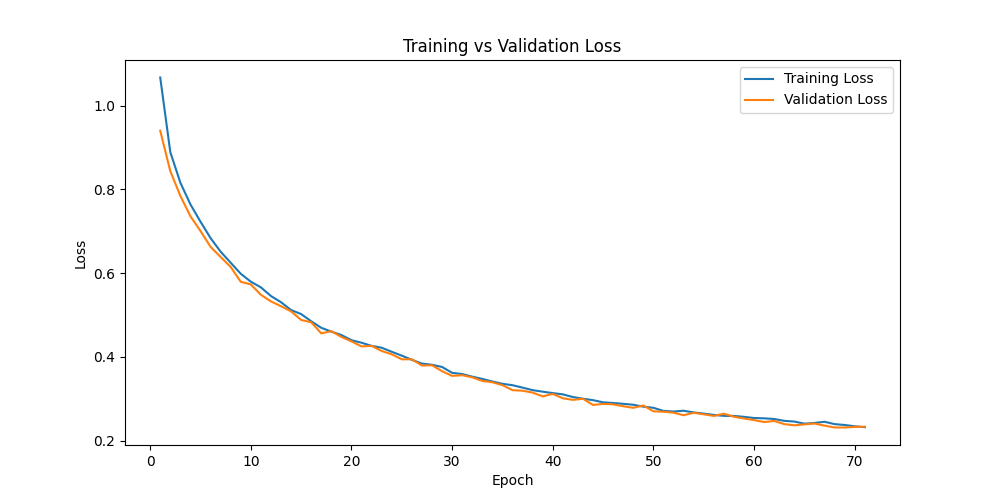

In [13]:
epochs = range(1, len(all_train_loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, all_train_loss, label='Training Loss')
plt.plot(epochs, all_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [14]:
import datetime

# datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S%z")
tz = datetime.timezone.utc
ft = "%Y_%m_%d_%H_%M_%S_%z"
t = datetime.datetime.now(tz=tz).strftime(ft)
# print(t)

CKPT_FILE = os.path.join('trained_models',f'PPG_PEAK_DETECTION_MODEL_{epoch}_{t}.pth')
# CKPT_FILE = os.path.join('trained_models',"PPG_PEAK_DETECTION_MODEL_63_2025_04_21_06_05_56_+0000.pth")
print(CKPT_FILE)
# save weights
torch.save(model.state_dict(), CKPT_FILE)
print('Checkpoint saved.')


trained_models/PPG_PEAK_DETECTION_MODEL_72_2025_04_21_15_28_23_+0000.pth
Checkpoint saved.


In [15]:
FOLDER_PATH = 'length_full'
TEST_PATH = os.path.join('data',FOLDER_PATH,'test_ds.h5')  # update if your file lives elsewhere
# CKPT     = CKPT_FILE
CKPT = os.path.join('trained_models',"PPG_PEAK_DETECTION_MODEL_72_2025_04_21_15_28_23_+0000.pth")
# CKPT = os.path.join('checkpoints',"ckpt_epoch_NN_RL_70.pth")
if not os.path.exists(TEST_LOADER_PATH):
    test_ds = PPGWindow(TEST_PATH,best_config=best_config,scale_type=scale_type)
    torch.save(test_ds,TEST_LOADER_PATH)
else:
    test_ds = torch.load(TEST_LOADER_PATH,weights_only=False)

test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)

# ------------ load the trained model -------------------------------------
model  = UNet1D().to(device)
model.load_state_dict(torch.load(CKPT, map_location=device))
model.eval()



UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv1d(16, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (net): Sequential(
        (0): Co

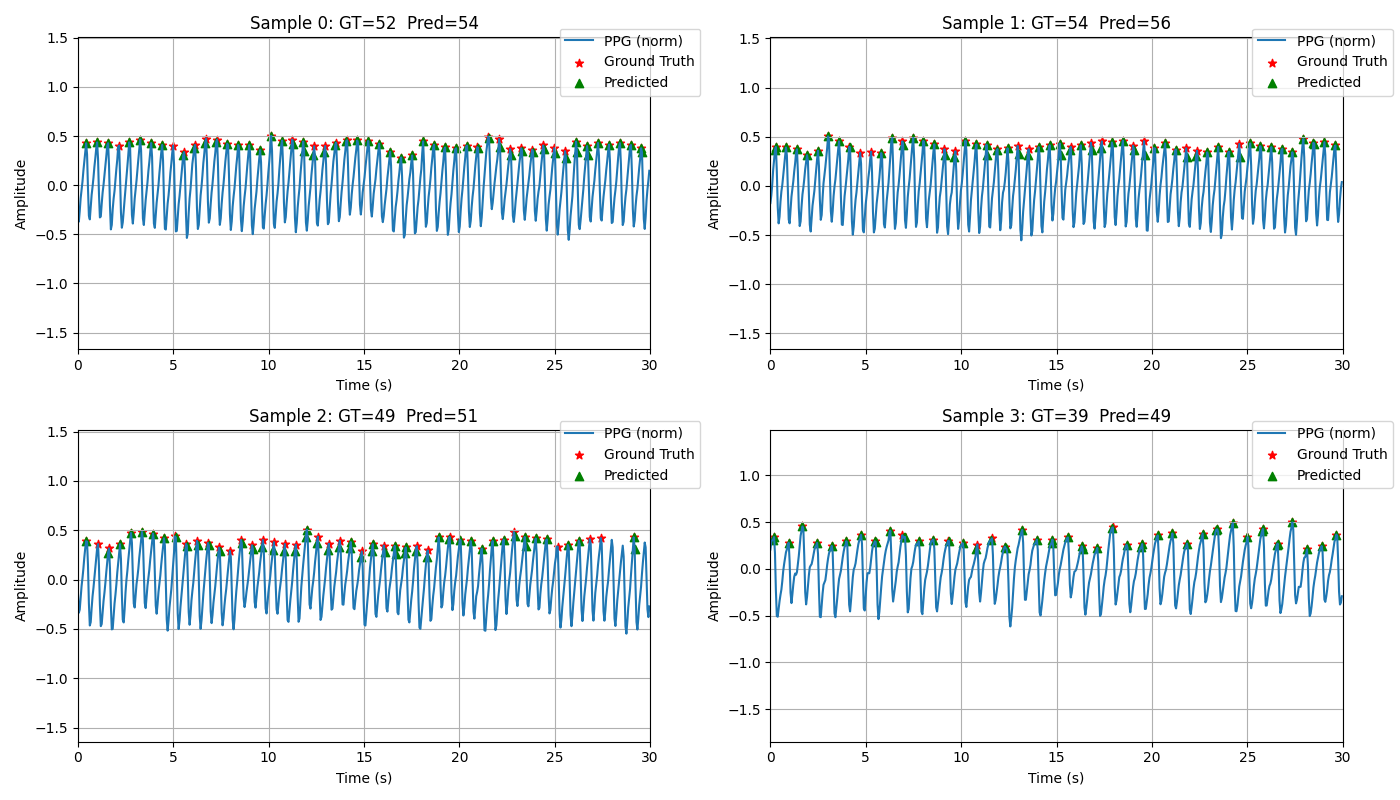

In [24]:
THRESH   = 0.9         # probability cut‑off for “peak”
xb, yb, orig,_ = next(iter(test_loader))     # xb: (B,1,L), yb: (B,L), orig:(B,1,L)
xb, yb, orig = xb.to(device), yb.to(device), orig  # orig can stay on CPU

yb_cpu = yb.cpu().numpy()          # shape (B, L)

B, _, L = xb.shape
t = np.arange(L) / FS  # common time axis, shape (L,)
# print(t)
# How many to plot

n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*4), squeeze=False)

# fig2, axes2 = plt.subplots(rows, cols, figsize=(cols*7, rows*4), squeeze=False)

for i in range(n_plot):
    ax = axes[i//cols][i%cols]
    # ax1 = axes2[i//cols][i%cols]
    # 1) model forward only this window
    
    # 1) raw 625‐point window
    original_window = orig[i,0].numpy()   # shape (L,)
    # if you had inverted sign elsewhere:
    original_window = -original_window

    # 2) normalized window
    window_norm = xb[i,0].cpu().numpy()   # shape (L,)
    # if you invert:
    window_norm = -window_norm

    # 3) model prediction for this window
    inp  = xb[i:i+1].to(device)            # shape (1,1,L)
    # print(inp)   
    with torch.no_grad():
        prob = torch.sigmoid(model(inp))[0]  # shape (L,)
    prob_np    = prob.cpu().numpy()
    peaks_pred = np.where(prob_np > THRESH)[0]

    # 4) ground‑truth peaks from yb
    gt_peaks = np.where(yb_cpu[i] > 0)[0]
    # 5) now plot
    # ax.plot(t, original_window, label='PPG (raw)', alpha=0.7)
    ax.plot(t, window_norm,label='PPG (norm)', linestyle='-')
    ax.scatter(t[gt_peaks], window_norm[gt_peaks],
               c='r', marker='*', label='Ground Truth')
    ax.scatter(t[peaks_pred], window_norm[peaks_pred],
               c='g', marker='^', label='Predicted')


    ax.set_title(f"Sample {i}: GT={len(gt_peaks)}  Pred={len(peaks_pred)}")
    ax.set_xlim(0, WIN_SEC)
    ax.set_ylim(np.min(window_norm)*3, np.max(window_norm)*3)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1.05))
    ax.grid()


    # ax1.hist(np.diff(t[peaks_pred]))

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
all_test_loss = [];
cumulative_test_loss = 0.0
with torch.no_grad():
    for xb, yb,_,_ in tqdm(test_loader, desc=f'Val\t | Epoch {epoch+1}/{EPOCHS}'):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        with torch.autocast("mps", dtype=torch.bfloat16):
            logits = model(xb).float()
            test_loss   = criterion(logits, yb)
        if torch.isnan(validation_loss): raise ValueError('NaN loss')
        cumulative_test_loss += validation_loss.item() * xb.size(0)

mean_val = cumulative_test_loss / (len(test_loader.dataset))
all_test_loss.append(mean_val)